In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os

from stompy.grid import unstructured_grid
import stompy.model.data_comparison as dc

import stompy.model.delft.dflow_model as dfm
import pesca_base

INFO:DFlowModel:DelwaqScalarBC instantiated.


In [2]:
%matplotlib notebook

In [3]:
# Load the ESA dataset:
esa_waterlevel=xr.open_dataset("../calibration/esa_compiled_waterlevel.nc")

In [4]:
# Load BML dataset:
bml_data_dir="../../data/BML data/2016/all_concatenated"

# BC1 starts later.  All other sites okay for this period.
df=pd.read_csv(os.path.join(bml_data_dir,'csv','NCK_wll_concatenated.csv'))
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
nck_wll=df.set_index('time')
nck_wll.head()

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,year,month,day,hour,minute,second,depth m,temp degC,Unnamed: 8
time,,,,,,,,,
2016-04-06 23:24:00,2016,4,6,23,24,0,11.657694,13.846,NaN
2016-04-06 23:27:00,2016,4,6,23,27,0,11.656686,13.269,NaN
2016-04-06 23:30:00,2016,4,6,23,30,0,11.654668,12.980,NaN
2016-04-06 23:33:00,2016,4,6,23,33,0,11.652651,12.883,NaN
2016-04-06 23:36:00,2016,4,6,23,36,0,11.648617,12.787,NaN


In [5]:
# Updated test, using BML data
if 1:
    observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')
    model55=pesca_base.PescaButano.load('run_salt_20160520-v55')    
    model=model55

In [6]:
bcs=model.load_bcs()

Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd


In [8]:
ocean_bc=[bc for bc in bcs if bc['name']=='ocean_bc'][0]
# ocean_bc

In [9]:
from stompy.io.local import noaa_coops

mb_gauge=noaa_coops.coops_dataset_product(station=9413450,
                                          product='water_level',
                                          start_date=model.run_start,
                                          end_date=model.run_stop,
                                          cache_dir='cache')

an_gauge=noaa_coops.coops_dataset_product(station=9413878,
                                          product='predictions',
                                          interval='hilo',
                                          start_date=model.run_start,
                                          end_date=model.run_stop,
                                          cache_dir='cache')

INFO:noaa_coops:Cached   2016-05-01 00:00:00 -- 2016-06-01 00:00:00
INFO:noaa_coops:Cached   2016-06-01 00:00:00 -- 2016-07-01 00:00:00
INFO:noaa_coops:Cached   2016-07-01 00:00:00 -- 2016-08-01 00:00:00
INFO:noaa_coops:Cached   2016-05-01 00:00:00 -- 2016-06-01 00:00:00
INFO:noaa_coops:Fetching 2016-05-01 00:00:00 -- 2016-06-01 00:00:00
INFO:noaa_coops:Cached   2016-06-01 00:00:00 -- 2016-07-01 00:00:00
INFO:noaa_coops:Fetching 2016-06-01 00:00:00 -- 2016-07-01 00:00:00
INFO:noaa_coops:Fetching 2016-07-01 00:00:00 -- 2016-08-01 00:00:00


<IPython.core.display.Javascript object>


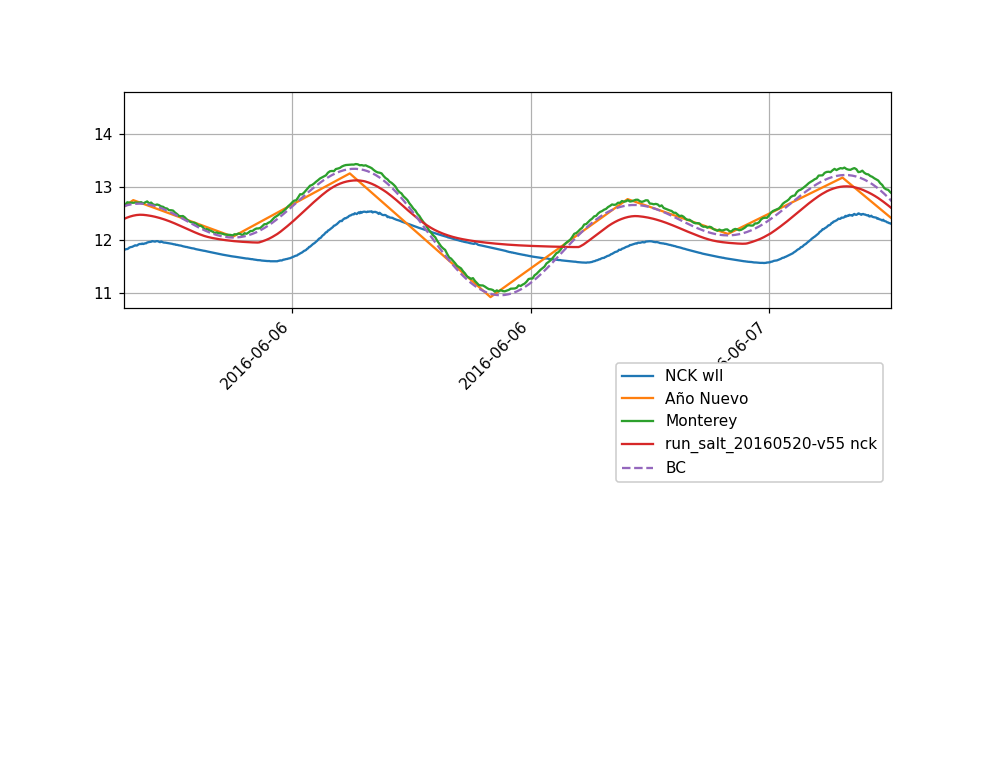

In [11]:
import six
six.moves.reload_module(dc)

sources=[observed]

sources.append( an_gauge.predictions.isel(station=0).assign_coords(label='Año Nuevo') )
sources.append( mb_gauge.water_level.isel(station=0).assign_coords(label='Monterey'))

for model in [model55]:
    his_ds=xr.open_dataset(model.his_output())

    for model_stn in [ b'nck' ]:
        sel=np.nonzero( his_ds['station_name'].values==model_stn )[0][0]
        predicted=his_ds['waterlevel'].isel(stations=sel)
        predicted=predicted.assign_coords(label=f'{model.run_dir} {model_stn.decode()}')
        sources.append(predicted)
    
    his_ds.close()

sources.append( ocean_bc['data']['stage'].isel(node=0).assign_coords(label='BC'))

# sources[1]['label']=(),'Open mouth, no constriction'
# sources[2]['label']=(),'Open mouth, partial constriction'
fig=dc.calibration_figure_3panel(sources,trim_time=False,lowpass=False,metric_x=None)
fig.axes[2].set_visible(0)
fig.axes[1].set_visible(0)

ax=fig.axes[0]
ax.axis([16957.813032803748, 16958.72289133207, 
                  10.497886219416628, 13.38061368842699])

if 0:
    from matplotlib.ticker import FuncFormatter
    import matplotlib.dates as mdates

    hours = mdates.HourLocator(interval = 1)
    h_fmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)
    
plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
ax.grid(1)

ax.lines[4].set_linestyle('--')

ax.legend(loc='upper right',bbox_to_anchor=[1.0,-0.22],
          framealpha=1.0)

In [ ]:
fig.savefig('manytides.png',dpi=200)

Salinity Comparisons
--

In [15]:
his_ds=xr.open_dataset(model55.his_output())

In [20]:
nck_stn=np.nonzero( his_ds.station_name.values==b'nck' )[0][0]
nck_stn

7

In [23]:
model_nck_salt=his_ds.isel(stations=nck_stn).salinity
model_nck_salt

<xarray.DataArray 'salinity' (time: 17713, laydim: 14)>
[247982 values with dtype=float64]
Coordinates:
    station_x_coordinate  float64 5.524e+05
    station_y_coordinate  float64 4.124e+06
    station_name          |S64 b'nck'
    zcoordinate_c         (time, laydim) float64 ...
  * time                  (time) datetime64[ns] 2016-05-20 ... 2016-07-20T12:...
Dimensions without coordinates: laydim
Attributes:
    units:          1e-3
    geometry:       station_geom
    standard_name:  salinity

In [127]:
bml_nck_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/NCK_sfc_mcat_concatenated.csv")
bml_nck_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/NCK_btm_mcat_concatenated.csv")
bml_pc3_sfc_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/PC3_sfc_sonde_concatenated.csv")
bml_pc3_btm_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/PC3_btm_sonde_concatenated.csv")

for df in [bml_nck_sfc_mcat,
           bml_nck_btm_mcat,
           bml_pc3_sfc_sond,
           bml_pc3_btm_sond]:
    # UTC
    df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
    df.set_index('time',inplace=True)

In [128]:
class FigSalt:
    zoom=(16960.24667031317,
          16962.483944929114,
           -0.5475896244306924,
           36.366318197905606)
    layers=['surface','bottom'] # bed layer, and near-surface layer that is mostly wet.
    colors=['tab:blue','tab:orange']
    def __init__(self,ds,his_name,bml_sfc,bml_btm):
        stn=np.nonzero( ds.station_name.values==his_name )[0][0]
        stn_da=ds['salinity'].isel(stations=stn)
        
        # Pick out top/bottom finite values.
        scal=stn_da.values

        valid=np.isfinite(scal) # time,layer
        
        fig,ax=plt.subplots(figsize=(8,4.5))
        for col,lay in zip(self.colors,self.layers):
            if lay=='surface':
                surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
                lay_scal=np.choose(surf_idxs,scal.T)
                z_label="Surface"
            elif lay=='bottom':
                bed_idxs=np.argmax(valid,axis=1)
                lay_scal=np.choose(bed_idxs,scal.T) 
                z_label="Bottom"
            else:
                lay_scal=scal[:,lay]
                z=stn_da.zcoordinate_c.isel(laydim=lay).mean().values
                z_label=f"z={z:.2f} m"
            ax.plot(stn_da.time, lay_scal,
                    label=f"Model {z_label}", color=col, ls="--")

        ax.plot(bml_nck_sfc_mcat.index.values, bml_nck_sfc_mcat.salinity,
                color=self.colors[0],label="BML surface")
        ax.plot(bml_nck_btm_mcat.index.values, bml_nck_btm_mcat.salinity, 
                color=self.colors[1],label="BML bottom")

        ax.legend(loc='upper left',bbox_to_anchor=[1.01,1.0])
        ax.axis(xmin=model_nck_salt.time.values[0],
                 xmax=model_nck_salt.time.values[-1])
        fig.subplots_adjust(right=0.73)
        fig.autofmt_xdate()
        ax.axis( self.zoom )
        name=his_name.decode()
        ax.text(0.03,0.98,name,transform=ax.transAxes,va='top')
        

<IPython.core.display.Javascript object>


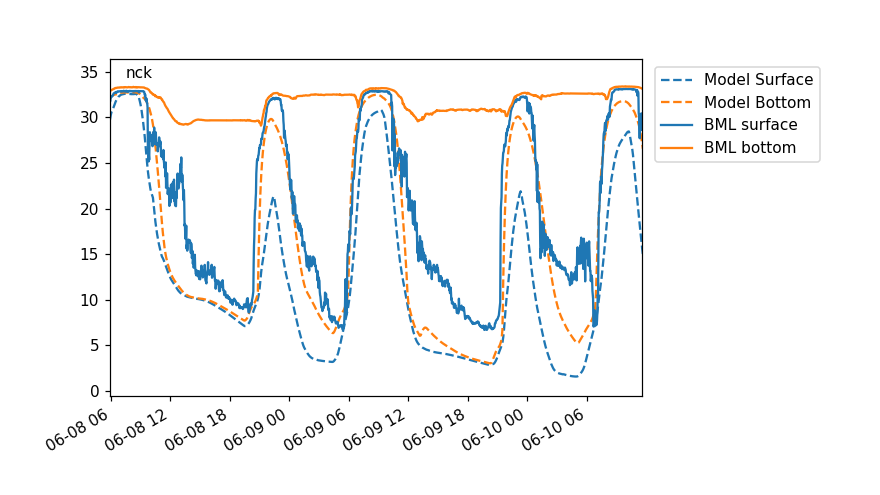

In [129]:
FigSalt(his_ds,b'nck',bml_nck_sfc_mcat,bml_nck_btm_mcat)

<IPython.core.display.Javascript object>


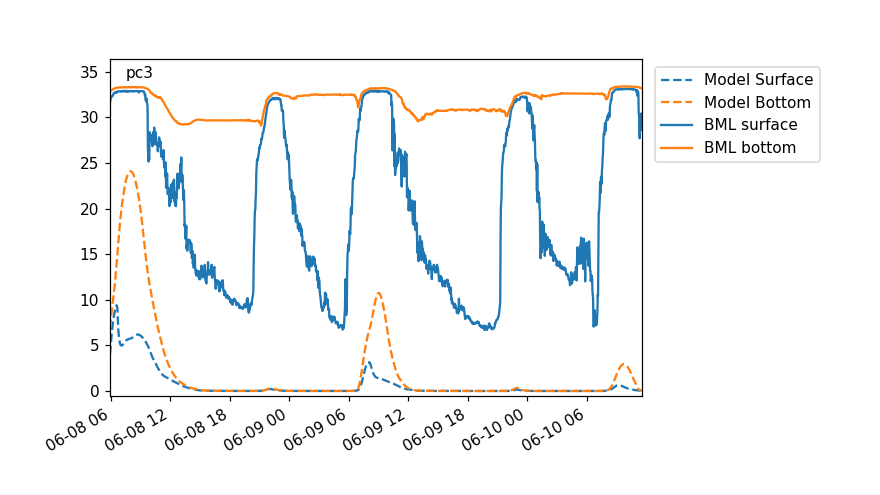

In [131]:
FigSalt(his_ds,b'pc3',bml_pc3_sfc_sond,bml_pc3_btm_sond)

In [141]:
bcs=model55.load_bcs()
bc_names=[bc['name'] for bc in bcs]
pesca_ck_bc=bcs[bc_names.index('pescadero_ck')]
butano_ck_bc=bcs[bc_names.index('butano_ck')]

Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd


In [148]:
# USGS gauge: 11162500
from stompy.io.local import usgs_nwis

usgs_nwis.nwis_dataset(11162500,start_date=pesca_ck_bc.time.values[0])

<IPython.core.display.Javascript object>


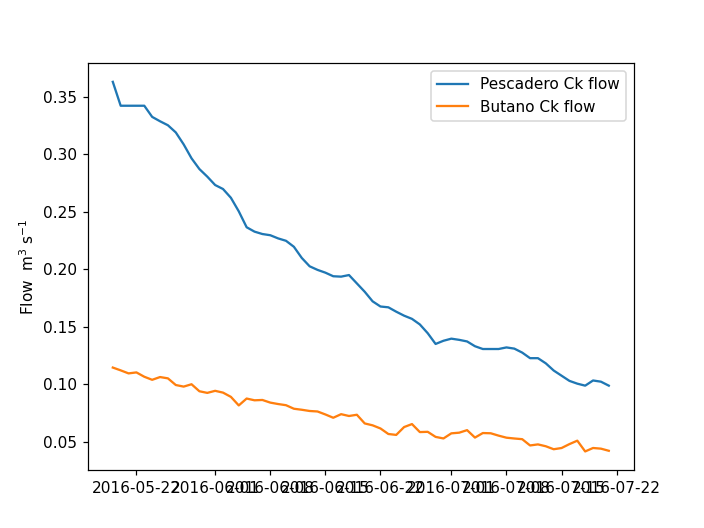

Text(0, 0.5, 'Flow  m$^3$ s$^{-1}$')

In [147]:
plt.figure()

Q=pesca_ck_bc['data']
plt.plot(Q.time, Q.flow, label="Pescadero Ck flow")

Q=butano_ck_bc['data']
plt.plot(Q.time, Q.flow, label="Butano Ck flow")
plt.legend()
plt.ylabel('Flow  m$^3$ s$^{-1}$')